In [1]:
import graphviz
import numpy as np
from scipy.sparse import csc_matrix, coo_matrix
from copy import deepcopy

In [3]:
def gen_tree(nodes_list, nodes_relation_dict, penalty=1.0, weights=None, visualize=True):
    """
    nodes_list: list of list, each list is a node
    nodes_relation_dict: dict, key is node name, value is a list of edges
            example: {0: [1,2]}; for edge representation always follow 0 is the ancestor, [1,2] is the descendant
    """
    num_nodes = len(nodes_list)
    if len(nodes_relation_dict) < num_nodes:
        for i in range(num_nodes):
            if i not in nodes_relation_dict:
                nodes_relation_dict[i] = []
    row_idxs = []
    col_idxs = []
    vals = []
    pseudo_idx = 0
    if visualize:
        dot = graphviz.Digraph(comment='Tree Structure')
    else:
        dot = None    
    for node_idx, descendants in nodes_relation_dict.items():
        if visualize:
            if len(nodes_list[node_idx]) == 0:
                label = f"pseudo_{pseudo_idx}"
                pseudo_idx += 1
            elif len(nodes_list[node_idx]) == 1:
                label = str(nodes_list[node_idx][0])
            else:
                if len(nodes_list[node_idx]) > 5:
                    label = f"[{min(nodes_list[node_idx])},...,{max(nodes_list[node_idx])}]"
                else:
                    label = ",".join(map(str,nodes_list[node_idx]))
            dot.node(str(node_idx), label)
        for descendant_idx in descendants:
            col_idxs.append(node_idx)
            row_idxs.append(descendant_idx)
            vals.append(1)
            if visualize:
                dot.edge(str(node_idx), str(descendant_idx))
    groups_bool = coo_matrix((vals, (row_idxs, col_idxs)), shape=(num_nodes, num_nodes), dtype=bool).tocsc()
    groups = []
    for i in range(num_nodes):
        group = deepcopy(nodes_list[i])
        working_set = np.where(groups_bool[:,i].toarray().flatten())[0].tolist()
        included_nodes = []
        while len(working_set) > 0:
            working_node_idx = working_set.pop(0)
            included_nodes.append(working_node_idx)
            temp = np.where(groups_bool[:,working_node_idx].toarray().flatten())[0].tolist()
            working_set += temp
        for d in included_nodes:
            group += nodes_list[d]
        groups.append(group)
    if weights is None:
        weights = np.sqrt(np.array([len(group) for group in groups]))
    # pointer to the first variable of each group
    own_variables = np.array([min(g) for g in groups], dtype=np.int32)
    # number of "root"(unique) variables in each group
    N_own_variables = np.array([len(node) for node in nodes_list], dtype=np.int32)
    tree = {'eta_g': weights * penalty, 'groups': groups_bool, 'own_variables': own_variables, 'N_own_variables': N_own_variables}
    return groups, tree, dot

G_0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
G_1: [0, 1, 2, 3, 4, 5]
G_2: [3, 4]
G_3: [5]
G_4: [6, 7, 8, 9]
G_5: [6, 7]
G_6: [8, 9]
G_7: [9]
own_variables: [0 0 3 5 6 6 8 9]
N_own_variables: [0 3 2 1 0 2 1 1]
groups: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


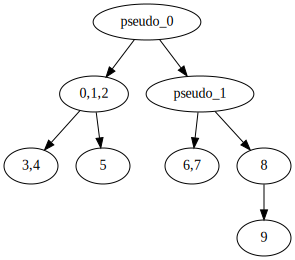

In [30]:
groups, tree, dot = gen_tree(nodes_list=[[], [0,1,2], [3,4], [5], [], [6,7], [8], [9]], nodes_relation_dict={0:[1,4], 1:[2,3], 4:[5,6], 6:[7]})
for i,g in enumerate(groups):
    print(f"G_{i}:", g)
print('own_variables:',tree['own_variables'])
print('N_own_variables:',tree['N_own_variables'])
print('groups:',tree['groups'].toarray()+0.0)
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree', directory='./vis_tree', cleanup=True, format='pdf')
dot

G_0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
G_1: [2, 3, 4]
G_2: [5, 6, 7, 8, 9, 10]
own_variables: [0 2 5]
N_own_variables: [2 3 6]
groups: [[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


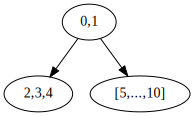

In [31]:
groups, tree, dot = gen_tree(nodes_list=[[0,1], [2,3,4], [5,6,7,8,9,10]], nodes_relation_dict={0:[1,2]})
for i,g in enumerate(groups):
    print(f"G_{i}:", g)
print('own_variables:',tree['own_variables'])
print('N_own_variables:',tree['N_own_variables'])
print('groups:',tree['groups'].toarray()+0.0)
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree', directory='./vis_tree', cleanup=True, format='pdf')
dot

G_0: [0, 1, 2, 3, 4, 5, 6, 7]
G_1: [1, 4, 5]
G_2: [2, 6, 7]
G_3: [3]
G_4: [4]
G_5: [5]
G_6: [6, 7]
G_7: [7]
own_variables: [0 1 2 3 4 5 6 7]
N_own_variables: [1 1 1 1 1 1 1 1]
groups: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


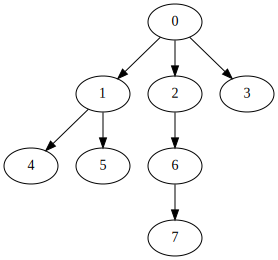

In [4]:
groups, tree, dot = gen_tree(nodes_list=[[0], [1], [2], [3], [4], [5], [6], [7]], nodes_relation_dict={0:[1,2,3], 1:[4,5], 2:[6], 6:[7]})
for i,g in enumerate(groups):
    print(f"G_{i}:", g)
print('own_variables:',tree['own_variables'])
print('N_own_variables:',tree['N_own_variables'])
print('groups:',tree['groups'].toarray()+0.0)
dot

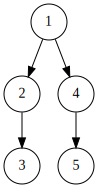

In [28]:
dot = graphviz.Digraph(comment='demo')
dot.attr('node', shape='circle')
dot.node('1', '1')
dot.node('2', '2')
dot.node('3', '3')
dot.node('4', '4')
dot.node('5', '5')
dot.edges(['12','14','23','45'])
dot.render(filename='demo', directory='./graphviz', cleanup=True, format='pdf')
dot

In [20]:
?dot.attr

Signature: dot.attr(kw: Optional[str] = None, _attributes=None, **attrs) -> None
Docstring:
Add a general or graph/node/edge attribute statement.

Args:
    kw: Attributes target
        (``None`` or ``'graph'``, ``'node'``, ``'edge'``).
    attrs: Attributes to be set (must be strings, may be empty).

See the :ref:`usage examples in the User Guide <attributes>`.
File:      ~/anaconda3/lib/python3.9/site-packages/graphviz/dot.py
Type:      method